In [1]:
%pylab inline
import webbpsf

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib
**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-051 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-055
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


# JWST Using OPDs Measured On Orbit


WebbPSF now includes code for using measured flight OPD files. These are produced by the JWST Wavefront Sensing Subsystem (WSS), using focus diverse phase retrieval on NIRCam weak lens data taken roughly every two days in flight. The output OPDs from that are saved in MAST and can be automatically retrieved and used in WebbPSF. 

Begin by instantiating an instrument instance in the usual manner. In this case, let's set up a NIRCam instance for one of the detectors in module B. 

In [2]:
nrc = webbpsf.NIRCam()
nrc.filter='F200W'

nrc.detector = 'NRCB2'
nrc.detector_position = (1024,1024)

To load an OPD corresponding to observations on some particular date, use the method `load_wss_opd_by_date`. This takes as its first argument a date time specified in ISO format, like "YYYY-MM-DDTHH:MM:SS".  

Let's also set `plot=True` so this makes a plot which shows what's going on.


MAST OPD query around UTC: 2022-07-01T00:00:00.000
                        MJD: 59761.0

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022063002-NRCA3_FP1-2.fits
	Date (MJD):	 59759.6628
	Delta time:	 -1.3372 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022070403-NRCA3_FP1-0.fits
	Date (MJD):	 59761.5484
	Delta time:	 0.5484 days
User requested choosing OPD time closest in time to 2022-07-01T00:00:00.000, which is R2022070403-NRCA3_FP1-0.fits, delta time 0.548 days
INFO: MAST API token accepted, welcome Marshall Perrin [astroquery.mast.auth]
Importing and format-converting OPD from /Users/mperrin/software/webbpsf-data/MAST_JWST_WSS_OPDs/R2022070403-NRCA3_FP1-0.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point


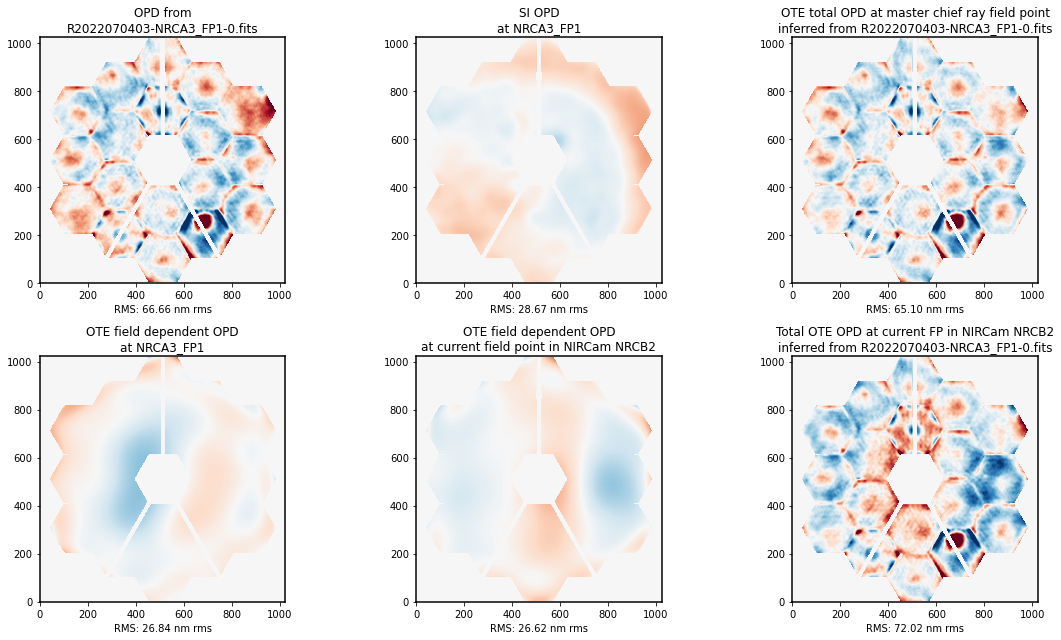

In [3]:
nrc.load_wss_opd_by_date('2022-07-01T00:00:00',plot=True)

Given the input date, the function queries to find the closest-in-time wavefront sensing result. In this case it is a measurement about 0.5 days after the specified time. (You can set keyword `choice='before'` or `choice='after'` if you have some reason to specify which in particular).  That OPD file will be automatically retrievd from MAST; downloads are cached inside your $WEBBPSF_DATA_PATH directory for reuse in multiple calculations.

Let's look at each plot in turn. 

* **Upper Left:** This is the measured OPD as sensed in NIRCam at "field point 1" which is in the upper left corner of NRCA3, relatively close to the center of the NIRCam module. This observatory total OPD measurement includes both the telescope and NIRCam contributions to the WFE.
* **Upper Middle:** This is the wavefront map for the NIRCam portion of the WFE at that field point. This is known from ground calibration test data, not measured in flight. 
* **Upper Right:** That NIRCam WFE contribution is subtracted from the total observatory WFE to yield this estimate of the OTE-only portion of the WFE.
* **Lower Left and Middle:** These are models for the field dependence of the OTE OPD between the sensing field point in NRCA3 and the requested field ooint, in this case in NRCB2. This field dependence arises mostly from the figure of the tertiary mirror. These are used to transform the estimated OTE OPD from one field position to another. 
* **Lower Right**: This is the resulting estimate for the OTE OPD at the requested field point, in this case in NRCB2. 

All those calculations happen automatically as part of the `load_wss_opd_by_date` (inside the `load_wss_opd` function which it calls in turn). 


After that it's just a matter of calculating PSFs as usual: 

In [4]:
psf = nrc.calc_psf(fov_pixels=101)

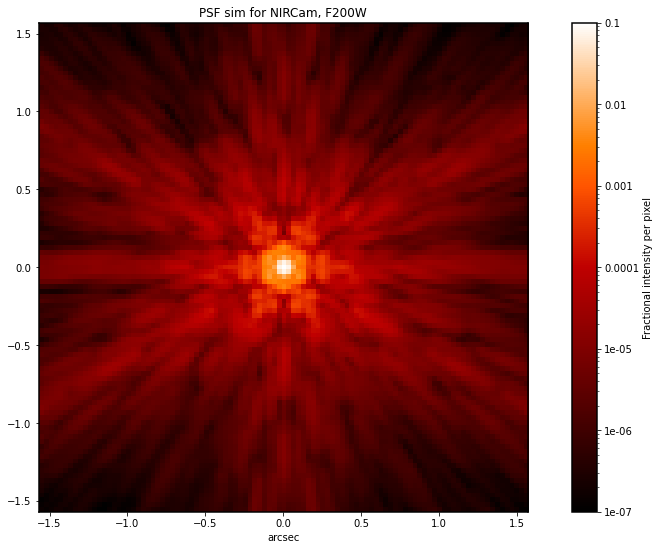

In [5]:
plt.figure(figsize=(16,9))
webbpsf.display_psf(psf, ext=1)

Thus, the above PSF is calculated using the actual as-measured-at-L2 state of the telescope WFE near the requested date, in this case 2022 July 1. 